# Home credit default risk (IITD, Prof. Niladri)

In [1]:
import os
from pathlib import Path

# IO + data
import pandas as pd
import polars as pl
import numpy as np

# viz
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Config

In [2]:
class CFG:
    NULL_CUTOFF = 0.8  # 0.8
    COL_MAX_UNIQUE_VALUES = 200  # 200
    SAMPLE_FRAC = 0.4  # works at 0.5, not at 0.76
    SEED = 13

We'll be splitting our work in three phases:
1. Data reading + analysis
2. Data cleaning + preprocessing
3. Model(s) and output

# ETL
## Reading the data

In [3]:
def get_available_files():
    files = []
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            files.append(os.path.join(dirname, filename))
    return files

get_available_files()

['/kaggle/input/home-credit-credit-risk-model-stability/sample_submission.csv',
 '/kaggle/input/home-credit-credit-risk-model-stability/feature_definitions.csv',
 '/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_deposit_1.parquet',
 '/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_applprev_2.parquet',
 '/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_static_cb_0.parquet',
 '/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_static_0_0.parquet',
 '/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_credit_bureau_a_1_3.parquet',
 '/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_credit_bureau_a_1_2.parquet',
 '/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_tax_registry_b_1.parquet',
 '/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_static_0_2.parquet',
 '/kag

We have our input data available in two formats - `csv` and `parquet`. `parquet` is a format used for tabular data storage and provides decent compression and enhanced performance. Let's compare the sizes of our files in either format.

https://en.wikipedia.org/wiki/Apache_Parquet

In [4]:
def get_folder_size(path='.'):
    size = 0
    for entry in os.scandir(path):
        if entry.is_file():
            size += entry.stat().st_size
        elif entry.is_dir():
            size += get_folder_size(entry.path)
    return size

{
    'csv': f'{get_folder_size("/kaggle/input/home-credit-credit-risk-model-stability/csv_files") * 1e-9:.2f}GB',
    'parquet': f'{get_folder_size("/kaggle/input/home-credit-credit-risk-model-stability/parquet_files") * 1e-9:.2f}GB',
}

{'csv': '25.44GB', 'parquet': '1.33GB'}

Hence proved. We're using `parquet`. :)

We also have a question of the library we'll be using to actually read our files. We have the standard `pandas` library, but there's a cool new competitor called `polars` which offers much better performance. We'll use that. It's also written in `rust`, which is awesome. :)

https://blog.jetbrains.com/dataspell/2023/08/polars-vs-pandas-what-s-the-difference/

In [5]:
ROOT = Path('/kaggle/input/home-credit-credit-risk-model-stability')

TRAIN_DIR = ROOT / 'parquet_files' / 'train'
TEST_DIR = ROOT / 'parquet_files' / 'test'

As for feature definitions, the team has given us a `feature_definitions.csv` file with our column names, and a list of transforms have been provided as suffixes. Let's see if there are any columns that don't need to be transformed accordingly.

In [6]:
feature_definitions_df = pl.read_csv('/kaggle/input/home-credit-credit-risk-model-stability/feature_definitions.csv')

feature_definitions_df.filter(~feature_definitions_df['Variable'].str.ends_with('P')
                              & ~feature_definitions_df['Variable'].str.ends_with('M')
                              & ~feature_definitions_df['Variable'].str.ends_with('A')
                              & ~feature_definitions_df['Variable'].str.ends_with('D')
                              & ~feature_definitions_df['Variable'].str.ends_with('T')
                              & ~feature_definitions_df['Variable'].str.ends_with('L'))

shape: (1, 2)
┌───────────┬─────────────────────────────────┐
│ Variable  ┆ Description                     │
│ ---       ┆ ---                             │
│ str       ┆ str                             │
╞═══════════╪═════════════════════════════════╡
│ score_940 ┆ Estimate of client's creditwor… │
└───────────┴─────────────────────────────────┘

Above, we can see that every column (with the exception of `score_940`, estimate of a client's trustworthiness) has to be transformed. The transformations are according to their suffixes:
- `P`: Transform DPD (Days past due)
- `M`: Masking categories
- `A`: Transform amount
- `D`: Transform date
- `T`: Unspecified Transform
- `L`: Unspecified Transform

Other than that, for certain files with `depth`, we have to apply aggregate transforms. These columns are titled `num_group1` and `num_group2`. It'd be best to come up with a set of aggregates to use on all dataframes as we load them.

## Aggregates and transforms (`Aggregates`)

In [7]:
class Aggregates:
    # TODO: alias the cols to "{col}_{'max'|'min'|'median'|'whatever'}" so that it's sorted correctly when we see it in the output
    aggr_fns = {
        'median': pl.median,
        'min': pl.min,
        'max': pl.max,
        'count': pl.count,
    }
    
    @staticmethod
    def __get_aggrs_for_fn(aggr_fn, cols):
        if aggr_fn not in Aggregates.aggr_fns:
            raise Exception(f'Unknown aggregator "{aggr_fn}"')
        
        return [Aggregates.aggr_fns[aggr_fn](col).alias(f'{aggr_fn}_{col}') for col in cols]
    
    @staticmethod
    def __get_aggrs(aggr_fns, cols):
        aggrs = []
        for aggr_fn in aggr_fns:
            aggrs += Aggregates.__get_aggrs_for_fn(aggr_fn, cols)

        return aggrs
    
    @staticmethod
    def num_aggr(df, aggr_fns=['median']):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        return Aggregates.__get_aggrs(aggr_fns, cols)
    
    @staticmethod
    def date_aggr(df, aggr_fns=['median']):
        cols = [col for col in df.columns if col[-1] in ("D")]
        return Aggregates.__get_aggrs(aggr_fns, cols)
    
    @staticmethod
    def str_aggr(df, aggr_fns=['median']):
        cols = [col for col in df.columns if col[-1] in ("M")]
        return Aggregates.__get_aggrs(aggr_fns, cols)
    
    @staticmethod
    def other_aggr(df, aggr_fns=['median']):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        return Aggregates.__get_aggrs(aggr_fns, cols)
    
    @staticmethod
    def count_aggr(df, aggr_fns=['median']):
        cols = [col for col in df.columns if "num_group" in col]
        return Aggregates.__get_aggrs(aggr_fns, cols)
    
    @staticmethod
    def get_aggregates(df, aggr_fns=['median']):
        aggrs = Aggregates.num_aggr(df, aggr_fns) + \
                Aggregates.date_aggr(df, aggr_fns) + \
                Aggregates.str_aggr(df, aggr_fns) + \
                Aggregates.other_aggr(df, aggr_fns) + \
                Aggregates.count_aggr(df, aggr_fns)

        return aggrs

Below are a set of methods for when we're loading our data

## Dataframe operations (`DataFrameOps`)
The above include setting datatypes, processing dates, dropping string cols with too many unique values and reducing memory usage (since we are easily running out of memory)

In [8]:
from pprint import pprint

class DataFrameOps:
    dropped_train_cols = None
    
    @staticmethod
    def set_dtypes(df):
        for col in df.columns:
            if col in ['case_id', 'WEEK_NUM', 'num_group1', 'num_group2']:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ['date_decision']:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ('P', 'A'):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ('M',):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ('D',):
                df = df.with_columns(pl.col(col).cast(pl.Date))
        return df
    
    @staticmethod
    def process_dates(df):
        processed_cols = []
        for col in df.columns:
            if col[-1] in ('D',):
                processed_cols.append(col)
                df = df.with_columns(pl.col(col) - pl.col('date_decision'))
                df = df.with_columns(pl.col(col).dt.total_days())
        
        print(f'DataFrameOps.process_dates / processed:')
        pprint(processed_cols)

        df = df.drop('date_decision')
        return df

    @staticmethod
    def drop_string_cols_with_numerous_values(df, is_test):
        if is_test:
            print(f'DataFrameOps.drop_string_cols_with_numerous_values / dropping for train values of:')
            pprint(DataFrameOps.dropped_train_cols)

            df = df.drop(list(DataFrameOps.dropped_train_cols))
            return df
        
        DataFrameOps.dropped_train_cols = {}
        
        for col in df.columns:
            if col in ['target', 'case_id', 'WEEK_NUM']:
                continue
            
            if df[col].dtype != pl.String:
                continue

            freq = df[col].n_unique()
            if freq == 1 or freq > CFG.COL_MAX_UNIQUE_VALUES:
                DataFrameOps.dropped_train_cols[col] = freq
        df.drop(list(DataFrameOps.dropped_train_cols))
            
        print(f'DataFrameOps.drop_string_cols_with_numerous_values:')
        pprint(DataFrameOps.dropped_train_cols)
        
        return df
    
    @staticmethod
    
    def reduce_memory_usage_pl(df):
        """
            Reduce memory usage by polars dataframe {df} by changing its data types.
            pandas version: https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 
            polars version: https://www.kaggle.com/code/demche/polars-memory-usage-optimization
        """
        start_memory_mb = round(df.estimated_size('mb'), 2)

        numeric_int_types = [pl.Int8, pl.Int16, pl.Int32, pl.Int64]
        numeric_flo_types = [pl.Float32, pl.Float64]

        for col in df.columns:
            col_type = df[col].dtype
            if col_type not in numeric_int_types or col_type not in numeric_flo_types:
                continue
            
            c_min, c_max = df[col].min(), df[col].max()
            if c_min is None or c_max is None:
                continue

            if col_type in numeric_int_types:
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df = df.with_columns(df[col].cast(pl.Int8))
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df = df.with_columns(df[col].cast(pl.Int16))
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df = df.with_columns(df[col].cast(pl.Int32))
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df = df.with_columns(df[col].cast(pl.Int64))
            elif col_type in numeric_flo_types:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df = df.with_columns(df[col].cast(pl.Float32))

        end_memory_mb = round(df.estimated_size('mb'), 2)
        print(f'DataFrameOps.reduce_memory_usage_pl / reduced memory usage from {start_memory_mb}MB to {end_memory_mb}MB')

        return df

Finally, once the aggregations and table ops are set, we can load our files

## Reading the files (`ParquetReader`)

In [9]:
class ParquetReader:
    @staticmethod
    def read(path, depth=None):
        df = pl.read_parquet(path)
        df = df.pipe(DataFrameOps.set_dtypes)
        
        if depth in [1, 2]: # could replace with `if depth`
            df = df.group_by('case_id').agg(Aggregates.get_aggregates(df))

        return df
    
    @staticmethod
    def read_multiple(paths, depth=None):
        chunks = [ParquetReader.read(path, depth) for path in paths]
        
        df = pl.concat(chunks, how='vertical_relaxed')
        # drop any duplicates
        df = df.unique(subset=['case_id'])
        
        return df

And we should somehow merge the loaded parquet files.
## Feature engineer and merge dataframes

In [10]:
def feature_engineer_and_merge_dataframes(base, depth_0, depth_1, depth_2, is_test):
    base = base.with_columns(
        year_decision = pl.col('date_decision').dt.year(),
        month_decision = pl.col('date_decision').dt.month(),
        weekday_decision = pl.col('date_decision').dt.weekday())

    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        base = base.join(df, how='left', on='case_id', suffix=f'_{i}')
        
    base = base.pipe(DataFrameOps.process_dates)
#     base = base.pipe(DataFrameOps.drop_string_cols_with_numerous_values, is_test)
    base = base.pipe(DataFrameOps.reduce_memory_usage_pl)
    
    return base

LETS REEAAAAADDDDDDDDDD THEM DATAS

In [11]:
train_df = feature_engineer_and_merge_dataframes(
    base=ParquetReader.read(TRAIN_DIR / 'train_base.parquet'),
    depth_0=[
        ParquetReader.read_multiple([
            TRAIN_DIR / 'train_static_0_0.parquet',
            TRAIN_DIR / 'train_static_0_1.parquet',
        ]),
        ParquetReader.read(TRAIN_DIR / 'train_static_cb_0.parquet'),
    ],
    depth_1=[
        ParquetReader.read_multiple([
            TRAIN_DIR / 'train_applprev_1_0.parquet',
            TRAIN_DIR / 'train_applprev_1_1.parquet',
        ], depth=1),
        ParquetReader.read(TRAIN_DIR / 'train_other_1.parquet', depth=1),
        ParquetReader.read(TRAIN_DIR / 'train_tax_registry_a_1.parquet', depth=1),
        ParquetReader.read(TRAIN_DIR / 'train_tax_registry_b_1.parquet', depth=1),
        ParquetReader.read(TRAIN_DIR / 'train_tax_registry_c_1.parquet', depth=1),
        ParquetReader.read_multiple([
            TRAIN_DIR / 'train_credit_bureau_a_1_0.parquet',
            TRAIN_DIR / 'train_credit_bureau_a_1_1.parquet',
            TRAIN_DIR / 'train_credit_bureau_a_1_2.parquet',
            TRAIN_DIR / 'train_credit_bureau_a_1_3.parquet',
        ], depth=1),
        ParquetReader.read(TRAIN_DIR / 'train_credit_bureau_b_1.parquet', depth=1),
        ParquetReader.read(TRAIN_DIR / 'train_deposit_1.parquet', depth=1),
        ParquetReader.read(TRAIN_DIR / 'train_person_1.parquet', depth=1),
        ParquetReader.read(TRAIN_DIR / 'train_debitcard_1.parquet', depth=1),
    ],
    depth_2=[
        ParquetReader.read(TRAIN_DIR / 'train_applprev_2.parquet', depth=2),
        ParquetReader.read(TRAIN_DIR / 'train_person_2.parquet', depth=2),
        ParquetReader.read_multiple([
            TRAIN_DIR / 'train_credit_bureau_a_2_0.parquet',
            TRAIN_DIR / 'train_credit_bureau_a_2_1.parquet',
            TRAIN_DIR / 'train_credit_bureau_a_2_2.parquet',
            TRAIN_DIR / 'train_credit_bureau_a_2_3.parquet',
            TRAIN_DIR / 'train_credit_bureau_a_2_4.parquet',
            TRAIN_DIR / 'train_credit_bureau_a_2_5.parquet',
            TRAIN_DIR / 'train_credit_bureau_a_2_6.parquet',
            TRAIN_DIR / 'train_credit_bureau_a_2_7.parquet',
            TRAIN_DIR / 'train_credit_bureau_a_2_8.parquet',
            TRAIN_DIR / 'train_credit_bureau_a_2_9.parquet',
            TRAIN_DIR / 'train_credit_bureau_a_2_10.parquet',
        ], depth=2),
        ParquetReader.read(TRAIN_DIR / 'train_credit_bureau_b_2.parquet', depth=2),
    ],
    is_test=False
)

DataFrameOps.process_dates / processed:
['datefirstoffer_1144D',
 'datelastinstal40dpd_247D',
 'datelastunpaid_3546854D',
 'dtlastpmtallstes_4499206D',
 'firstclxcampaign_1125D',
 'firstdatedue_489D',
 'lastactivateddate_801D',
 'lastapplicationdate_877D',
 'lastapprdate_640D',
 'lastdelinqdate_224D',
 'lastrejectdate_50D',
 'lastrepayingdate_696D',
 'maxdpdinstldate_3546855D',
 'payvacationpostpone_4187118D',
 'validfrom_1069D',
 'assignmentdate_238D',
 'assignmentdate_4527235D',
 'assignmentdate_4955616D',
 'birthdate_574D',
 'dateofbirth_337D',
 'dateofbirth_342D',
 'responsedate_1012D',
 'responsedate_4527233D',
 'responsedate_4917613D',
 'median_approvaldate_319D',
 'median_creationdate_885D',
 'median_dateactivated_425D',
 'median_dtlastpmt_581D',
 'median_dtlastpmtallstes_3545839D',
 'median_employedfrom_700D',
 'median_firstnonzeroinstldate_307D',
 'median_recorddate_4527225D',
 'median_deductiondate_4917603D',
 'median_processingdate_168D',
 'median_dateofcredend_289D',
 'medi

In [12]:
# Sample
def do_sample(df):
    original_length = len(df)
    df = df.sample(fraction=CFG.SAMPLE_FRAC, seed=CFG.SEED, shuffle=True)
    new_length = len(df)
    
    print(f'We\'ve gone from {original_length} rows to {new_length} rows')
    
    return df

train_df = do_sample(train_df)

We've gone from 1526659 rows to 610663 rows


I can't be 100% sure that the above works flawlessly, but we do what we can with what we've got.

# EDA
_(we're finally here, phew)_

Let's first start by plotting how well formed our data is - how many nullish columns do we have?
## Seeing nullish columns

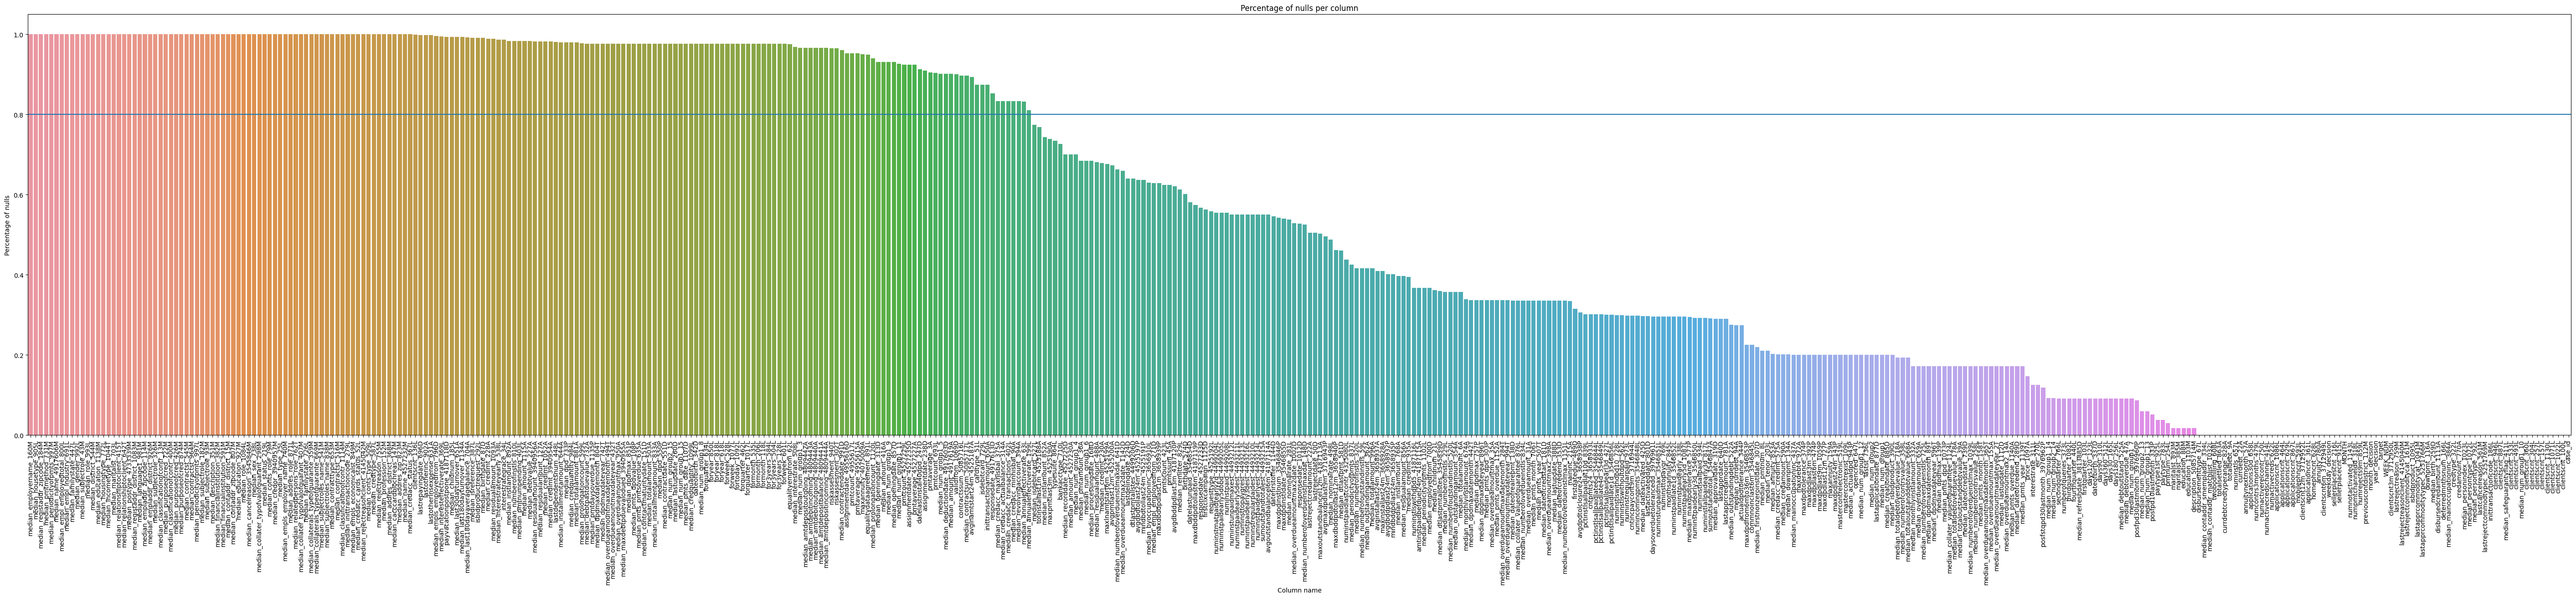

In [13]:
def plot_nulls(df):
    fig, ax = plt.subplots(figsize=(72, 12))

    def get_null_stats(col):
        null_count = df[col].is_null().sum()
        return { 'name': col, 'null_count': null_count, 'null_percentage': null_count / len(df) }

    null_df = pd.DataFrame([get_null_stats(col) for col in df.columns])
    null_df = null_df.sort_values('null_percentage', ascending=False)
    
    sns.barplot(null_df, x='name', y='null_percentage')
    plt.axhline(y=CFG.NULL_CUTOFF, linestyle='-')
    plt.xticks(rotation=90)
    
    ax.set_xlabel('Column name')
    ax.set_ylabel('Percentage of nulls')
    ax.set_title('Percentage of nulls per column')

    return null_df

train_null_stats_df = plot_nulls(train_df)

In [14]:
train_null_stats_df[train_null_stats_df['null_percentage'] > CFG.NULL_CUTOFF]

name  null_count  null_percentage
282          median_employername_160M      610663         1.000000
429             median_housetype_905L      610663         1.000000
421    median_registaddr_zipcode_184M      610663         1.000000
390             median_pmtmethod_731M      610663         1.000000
389     median_periodicityofpmts_997M      610663         1.000000
..                                ...         ...              ...
256  median_credacc_transactions_402L      509086         0.833661
231      median_credacc_minhisbal_90A      509086         0.833661
238      median_revolvingaccount_394A      509086         0.833661
334    median_annualeffectiverate_63L      508190         0.832194
333   median_annualeffectiverate_199L      495278         0.811050

[193 rows x 3 columns]

As we can see above, a lot of columns have simply null values, and since they don't provide much information, we should be good to drop these entirely.

Some such columns could be informational, but we're just dumping them for now. In the case that we need to get the absolute best performance out of our system, we'd look at columns individually and figure out whether we can drop them or not.

For now, we'll just drop all columns with more null values than specified in `CFG.NULL_CUTOFF`.

In [15]:
# TODO: this can be done in the loading phase itself, while we're doing much of the string removing math as well.
def drop_nullish_columns(df, null_stats_df):
    original_df_shape = df.shape

    for col in [colname for colname in null_stats_df[null_stats_df['null_percentage'] > CFG.NULL_CUTOFF]['name']]:
        df = df.drop(col)

    updated_df_shape = df.shape
    
    return df, original_df_shape, updated_df_shape

train_df, old_shape, new_shape = drop_nullish_columns(train_df, train_null_stats_df)

old_shape, new_shape

((610663, 489), (610663, 296))

## Correlation matrix
We won't be able to find correlations between date types without transforming them to a different numerical column, so we'll drop them while calculating our correlation matrix.

We also won't be able to find correlations between string types without first converting those to categorical.

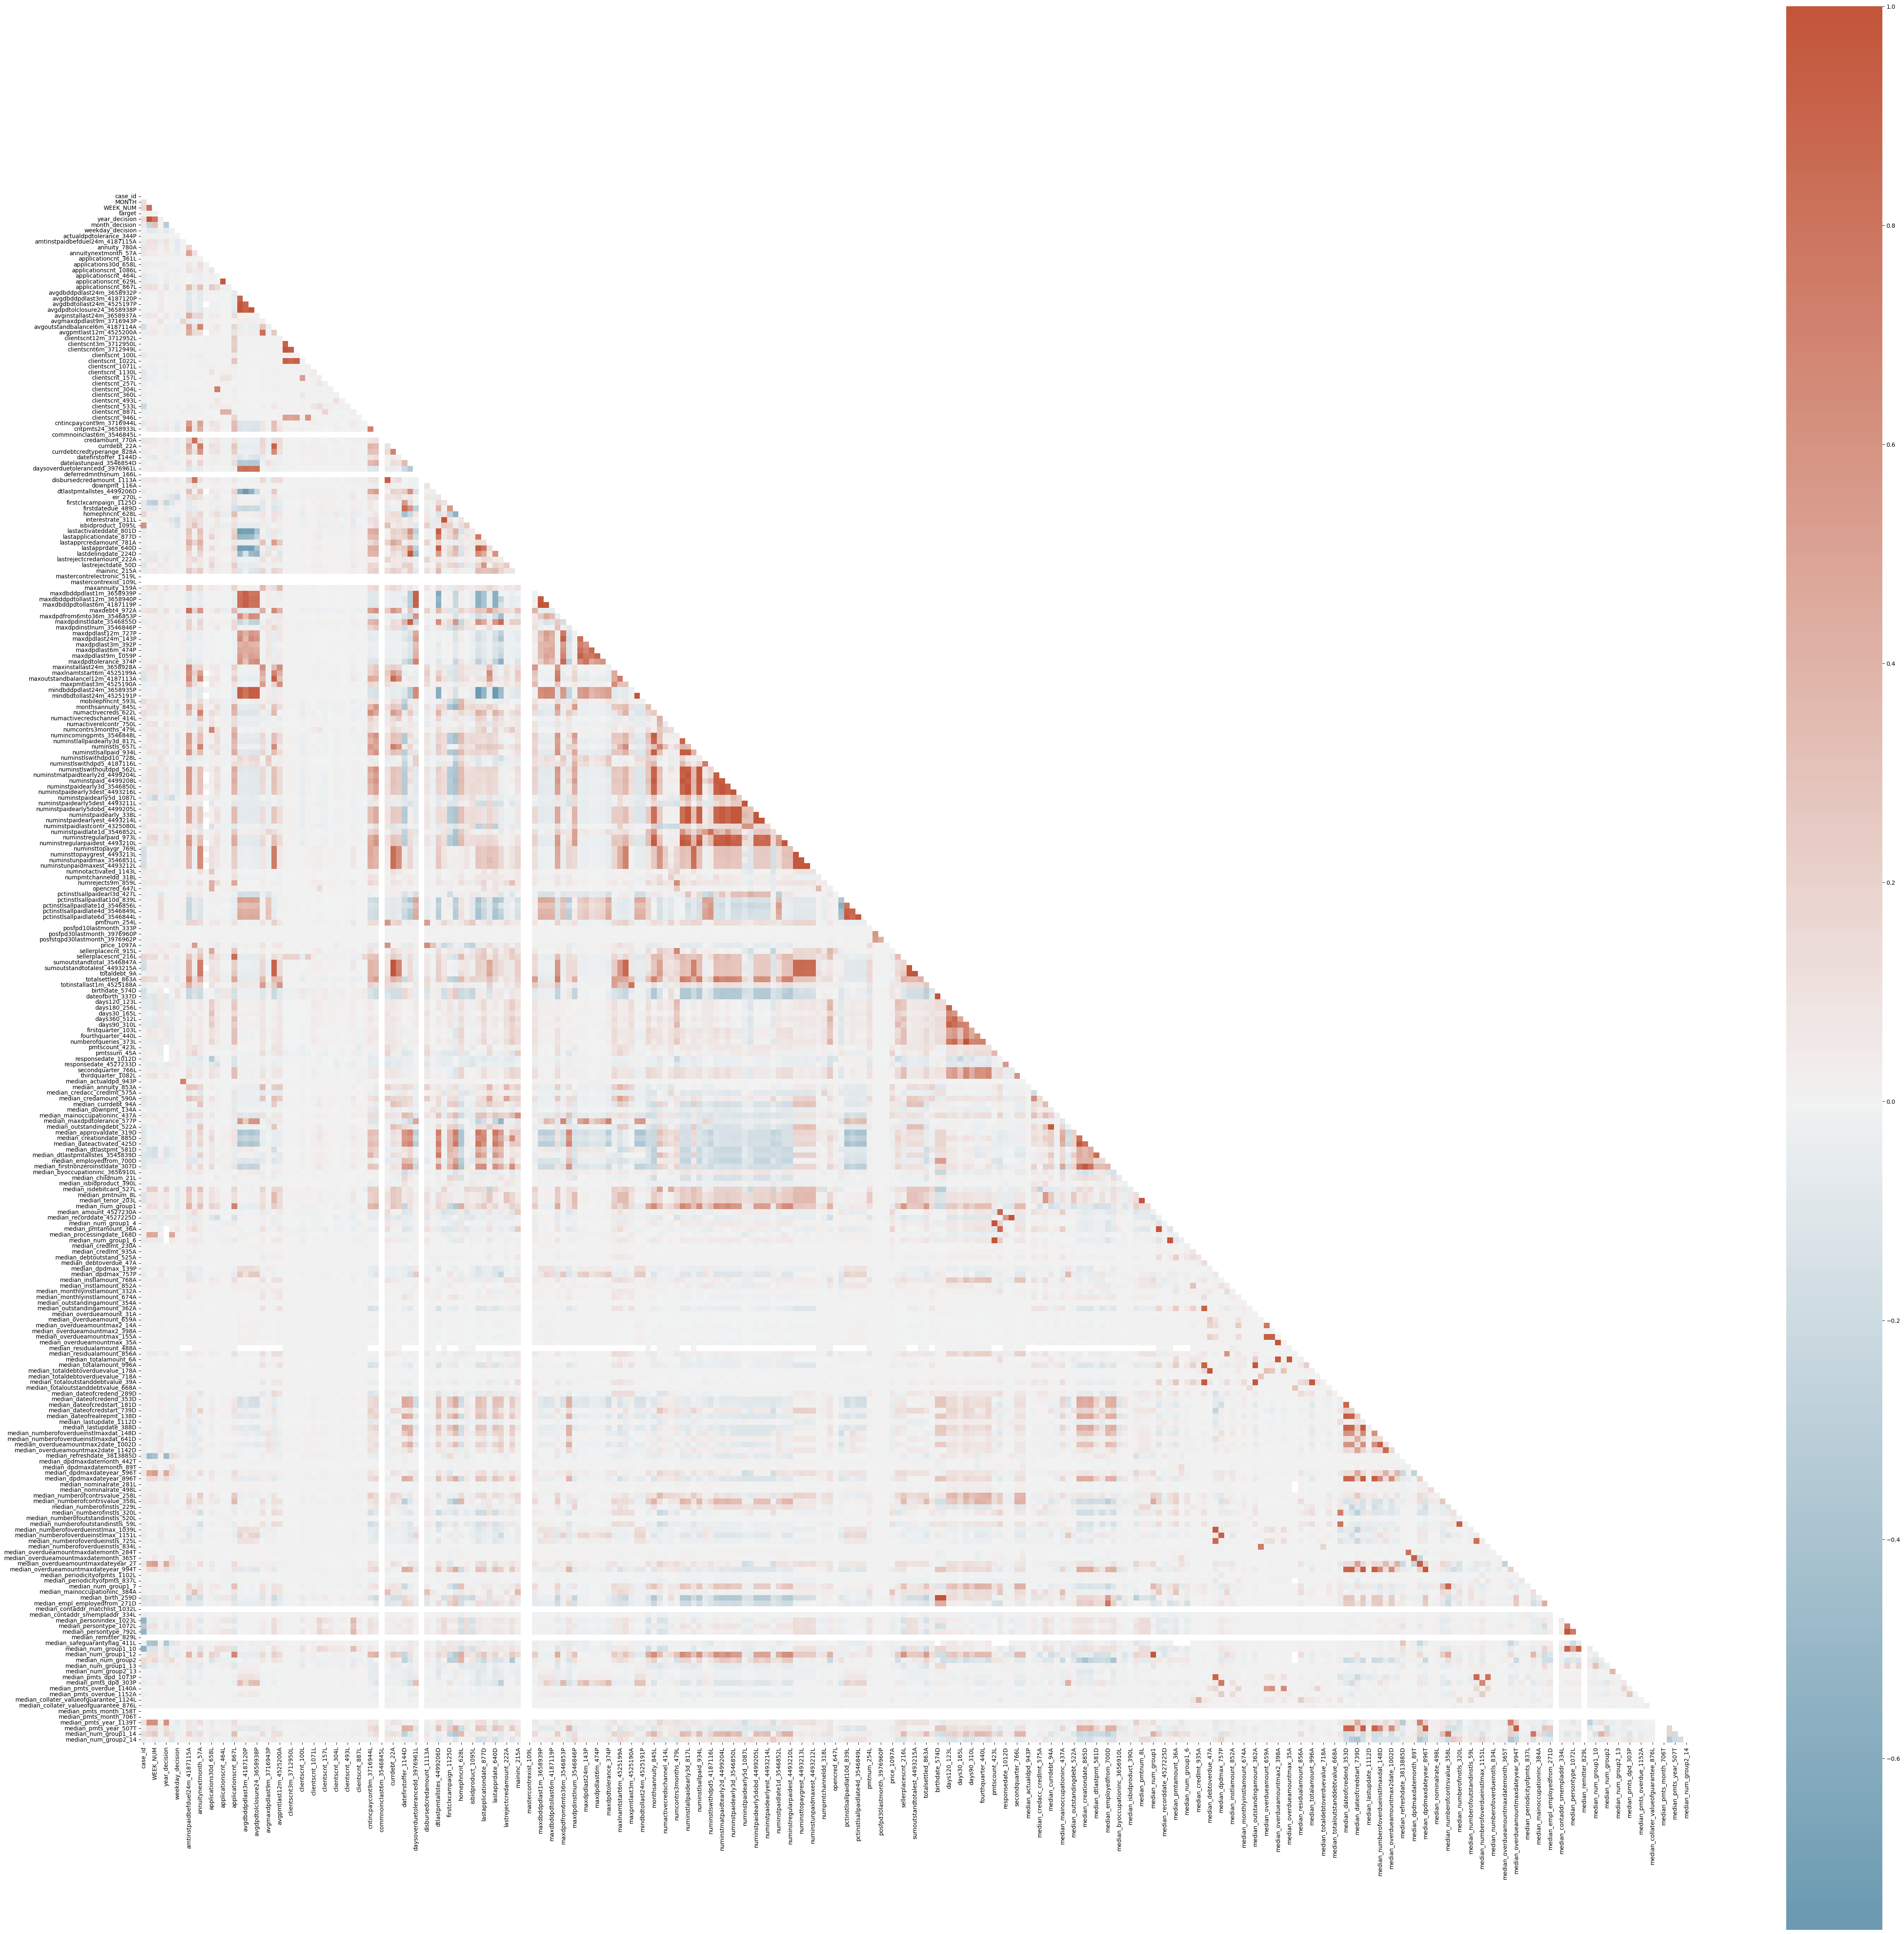

In [16]:
def plot_correlation_matrix(df):
    # to_pandas because polars returns nulls if a single value in the column is null
    corr = df.select(~pl.selectors.by_dtype(pl.Date, pl.String)).to_pandas().corr()
    
    _, (ax1) = plt.subplots(figsize=(60, 60))

    sns.heatmap(corr, vmax=1, center=0, square=True,
                mask=np.triu(np.ones_like(corr, dtype=bool)),
                cmap=sns.diverging_palette(230, 20, as_cmap=True), ax=ax1)
    
    plt.show()

    return corr

_correlation_df = plot_correlation_matrix(train_df)

As we can see above, there is a significant negative correlation of `target` with `pctinstlsallpaidearl3d_427L`, `numinstpaidearly3dest_4493216L`, `numinstmatpaidtearly2d_4499204L`, `numinstpaidearly5dobd_4499205L`, `numinstpaidearlyest_4493214L`, `numinstpaidearly3d_3546850L`, `numinstlallpaidearly3d_817L`, and a positive correlation with `avgmaxdpdlast9m_3716943P`, `numinstlswithdpd10_728L`, `pctinstlsallpaidlat10d_839L`, `pctinstlsallpaidlate6d_3546844L`, `pctinstlsallpaidlate4d_3546849L` and `pctinstlsallpaidlate1d_3546856L`.

This is expected behavior. If the user has paid most of their installments early, then there's a higher chance that they are good with their credit and won't default - hence the negative correlation.
Au contraire, if all their installments are paid late, there's a higher chance they are bad with their credit and are more likely to default - hence the positive correlation.

In [17]:
print('Highest negative correlations:')
_correlation_df['target'].sort_values().head()

Highest negative correlations:


pctinstlsallpaidearl3d_427L       -0.088777
numinstmatpaidtearly2d_4499204L   -0.059249
numinstpaidearly3dest_4493216L    -0.059125
numinstpaidearly5dobd_4499205L    -0.055696
numinstpaidearlyest_4493214L      -0.055538
Name: target, dtype: float64

In [18]:
print('Highest positive correlations:')
_correlation_df['target'].sort_values(ascending=False).head(6)

Highest positive correlations:


target                             1.000000
pctinstlsallpaidlate1d_3546856L    0.126815
pctinstlsallpaidlate4d_3546849L    0.124358
pctinstlsallpaidlate6d_3546844L    0.121063
pctinstlsallpaidlat10d_839L        0.116353
avgmaxdpdlast9m_3716943P           0.099458
Name: target, dtype: float64

## Plot values over time

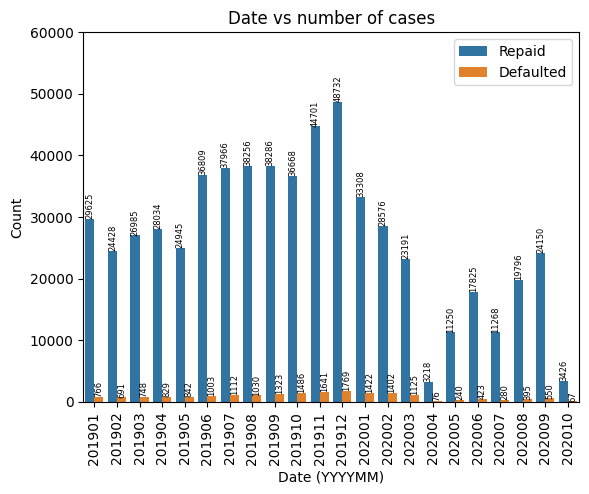

In [19]:
def plot_values_over_time(df):
    pd_df = train_df.to_pandas()
    ax = sns.countplot(pd_df, x='MONTH', hue='target')

    plt.ylim(0, 60000)
    plt.xticks(rotation=90)
    for container in ax.containers:
        ax.bar_label(container, rotation=90, fontsize=6)
        
    ax.legend(['Repaid', 'Defaulted'])
    ax.set_xlabel('Date (YYYYMM)')
    ax.set_ylabel('Count')
    ax.set_title('Date vs number of cases')

plot_values_over_time(train_df)

One really cool thing to see is the data that we have is right around covid - the loan defaults and repayments drop drastically ever since 201912, and dip to almost zero during the first wave. Fairly certain this will have an influence our training, so we'll probably need to stratify our data in phase 2. Let's have a look at how many defaults and repayments we have in 201912 and in 202004, so as to compare.

## Stats around covid-19 compared to a normal month

In [20]:
{
    '201912': {
        'defaulted': train_df.filter((train_df['MONTH'] == '201912') & (train_df['target'] == 1)).shape[0],
        'repaid': train_df.filter((train_df['MONTH'] == '201912') & (train_df['target'] == 0)).shape[0]
    },
    '202004': {
        'defaulted': train_df.filter((train_df['MONTH'] == '202004') & (train_df['target'] == 1)).shape[0],
        'repaid': train_df.filter((train_df['MONTH'] == '202004') & (train_df['target'] == 0)).shape[0]
    }
}

{'201912': {'defaulted': 1769, 'repaid': 48732},
 '202004': {'defaulted': 76, 'repaid': 3218}}

And what about the default rate over time?
## Rate of defaulting over time

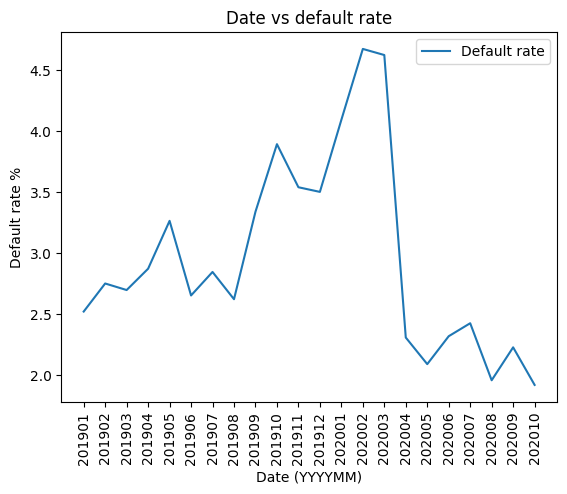

In [21]:
def plot_default_percentage_with_time(df):
    _df = df.group_by('MONTH').agg([pl.len().alias('total'), pl.sum('target').alias('defaults')])
    _df = _df.with_columns(pl.col('MONTH').cast(pl.Utf8))
    _df = _df.with_columns(default_rate=_df['defaults'] * 100 / _df['total'])
    _df = _df.to_pandas().sort_values('MONTH')

    fig, ax = plt.subplots()
    
    sns.lineplot(_df, x='MONTH', y='default_rate')
    plt.xticks(rotation=90)
    
    ax.legend(['Default rate'])
    ax.set_xlabel('Date (YYYYMM)')
    ax.set_ylabel('Default rate %')
    ax.set_title('Date vs default rate')
    
plot_default_percentage_with_time(train_df)

Above, we can see that the default rate slowly increases from August of 2019 onwards, all the way to April of 2020, which is when it stops. This is probably due to the banks being very selective to whom they give loans.
## Rate of defaulting as a function of the applicant's age

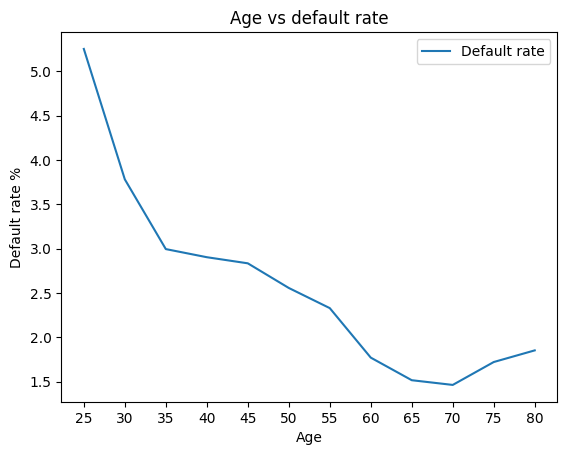

In [22]:
def plot_age_to_default(df):
    _df = df.select(['birthdate_574D', 'target']).drop_nulls()
    _df = _df.with_columns(pl.col('birthdate_574D') / -365)
    _df = _df.with_columns(pl.col('birthdate_574D').cut(range(0, 100, 5), labels=[f'{i}' for i in range(0, 101, 5)]).alias('age'))
    _df = _df.group_by('age').agg([pl.len().alias('count'), pl.sum('target').alias('defaults')])
    _df = _df.with_columns(default_rate=_df['defaults'] * 100 / _df['count'])
    _df = _df.to_pandas().sort_values('age')
        
    fig, ax = plt.subplots()
        
    sns.lineplot(_df, x='age', y='default_rate')
    
    ax.legend(['Default rate'])
    ax.set_xlabel('Age')
    ax.set_ylabel('Default rate %')
    ax.set_title('Age vs default rate')

plot_age_to_default(train_df)
# list()

Above, we can see that the likelihood of defaulting decreases with an increase in age. This is likely due to the fact that someone older usually has a longer career behind them, and is less likely to default due to it.
## Rate of defaulting as a function of the applicant's current debt

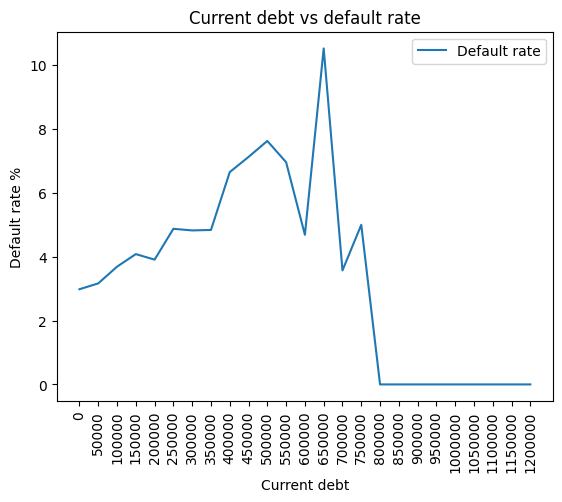

In [23]:
def plot_current_debt_to_default(df, nb_bins=None, bin_size=50000):
    _df = df.select(['currdebt_22A', 'target']).drop_nulls()
    
    min_debt, max_debt = int(df['currdebt_22A'].min()), int(df['currdebt_22A'].max())
    bin_size = (max_debt - min_debt) // nb_bins if nb_bins is not None else bin_size

    cut = list(range(min_debt, max_debt, bin_size))
    cut_labels = [f'{i}' for i in range(min_debt, max_debt + bin_size, bin_size)]

    _df = _df.with_columns(pl.col('currdebt_22A').cut(cut, labels=cut_labels).alias('debt'))
    _df = _df.group_by('debt').agg([pl.len().alias('count'), pl.sum('target').alias('defaults')])
    _df = _df.with_columns(default_rate=_df['defaults'] * 100 / _df['count'])
    _df = _df.to_pandas().sort_values('debt')
    
    fig, ax = plt.subplots()
    
    sns.lineplot(_df, x='debt', y='default_rate')
    plt.xticks(rotation=90)
    
    ax.legend(['Default rate'])
    ax.set_xlabel('Current debt')
    ax.set_ylabel('Default rate %')
    ax.set_title('Current debt vs default rate')

plot_current_debt_to_default(train_df)

Above, we can see that the likelihood of defaulting increases as the amount of debt increases. Fairly standard observation. The rate of defaulting is very low in the case of very high debts. This is probably due to the banks not approving loan requests for people with higher debts.
## Rate of defaulting as a function of the applicant's income

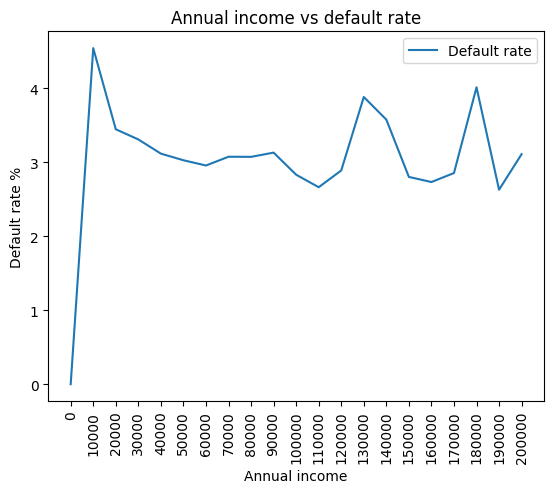

In [24]:
def plot_income_to_default(df, nb_bins=None, bin_size=10000):
    _df = df.select(['maininc_215A', 'target']).drop_nulls()
    
    fig, ax = plt.subplots()
    
    min_debt, max_debt = int(df['maininc_215A'].min()), int(df['maininc_215A'].max())
    bin_size = (max_debt - min_debt) // nb_bins if nb_bins is not None else bin_size

    cut = list(range(min_debt, max_debt, bin_size))
    cut_labels = [f'{i}' for i in range(min_debt, max_debt + bin_size, bin_size)]

    _df = _df.with_columns(pl.col('maininc_215A').cut(cut, labels=cut_labels).alias('income'))
    _df = _df.group_by('income').agg([pl.len().alias('count'), pl.sum('target').alias('approved')])
    _df = _df.with_columns(approval_rate=_df['approved'] * 100 / _df['count'])
    _df = _df.to_pandas().sort_values('income')
        
    sns.lineplot(_df, x='income', y='approval_rate')
    plt.xticks(rotation=90)

    ax.legend(['Default rate'])
    ax.set_xlabel('Annual income')
    ax.set_ylabel('Default rate %')
    ax.set_title('Annual income vs default rate')

plot_income_to_default(train_df)

As we can see above, the rate of defaulting is higher among low income groups, and then stabilizes around an income of \\$40000. Strangely, it increases around an income level of \\$120000. This could be due to higher income individuals opting for more expensive properties and larger loan amounts.
## Combined plot showing income and debt against likelihood of defaulting

CPU times: user 12.1 s, sys: 494 ms, total: 12.5 s
Wall time: 11.8 s


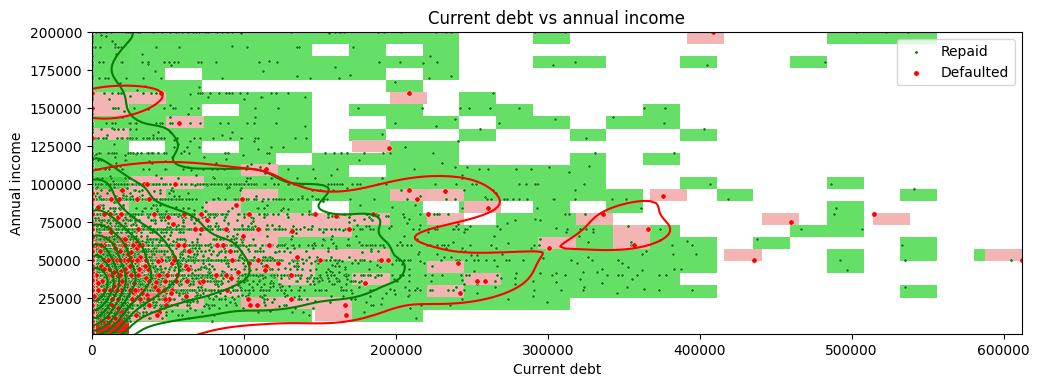

In [25]:
%%time

def plot_income_and_debt_against_default_rate(df, nb_samples=20000):
    _df = df.select(['maininc_215A', 'currdebt_22A', 'target']).sample(nb_samples, shuffle=True, seed=CFG.SEED).drop_nulls()
    
    f, ax = plt.subplots(figsize=(12, 8))
    ax.set_aspect('equal')
    
    plt.xlim(_df['currdebt_22A'].min(), _df['currdebt_22A'].max())
    plt.ylim(_df['maininc_215A'].min(), _df['maininc_215A'].max())
    
    default_df = _df.filter(pl.col('target') == 1)
    n_defau_df = _df.filter(pl.col('target') == 0)

    sns.kdeplot(n_defau_df, x='currdebt_22A', y='maininc_215A', color='green', levels=10)
    sns.kdeplot(default_df, x='currdebt_22A', y='maininc_215A', color='red', levels=2)

    sns.histplot(n_defau_df, x='currdebt_22A', y='maininc_215A', color='green', bins=25)
    sns.histplot(default_df, x='currdebt_22A', y='maininc_215A', color='red', bins=25)
    
    sns.scatterplot(n_defau_df, x='currdebt_22A', y='maininc_215A', color='green', s=5, label='Repaid')
    sns.scatterplot(default_df, x='currdebt_22A', y='maininc_215A', color='red', s=15, label='Defaulted')
    
    ax.legend()
    ax.set_xlabel('Current debt')
    ax.set_ylabel('Annual income')
    ax.set_title('Current debt vs annual income')
    
plot_income_and_debt_against_default_rate(train_df)

Above, we can see that there is a higher likelihood of a person defaulting if they're in a lower income group with a potentially higher debt. High income individuals have a lower chance of defaulting unless their debt is also equally high.

The higher the income, the lesser the chance of defaulting. The lower income groups with higher debts are at a very high chance of defaulting as compared to the rest of the sample.

Let's go ahead and plot the frequency of an applicant paying their installments early and paying their installments late against their chance of defaulting. These two columns are highly negatively and positively correlated with the target, and should provide some really good information.
## Combined plot showing the number of installments paid early and paid late against likelihood of defaulting

CPU times: user 9.35 s, sys: 509 ms, total: 9.86 s
Wall time: 9.03 s


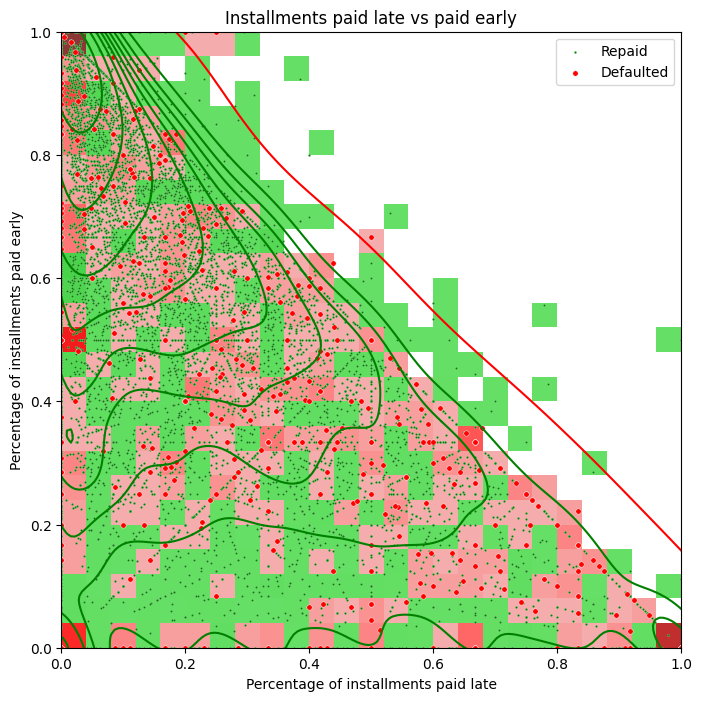

In [26]:
%%time

def plot_early_and_late_payments_against_default_rate(df, nb_samples=20000):
    _df = df.select(['pctinstlsallpaidearl3d_427L', 'pctinstlsallpaidlate1d_3546856L', 'target']).sample(nb_samples, shuffle=True, seed=CFG.SEED).drop_nulls()
    
    _df = _df.filter(pl.col('pctinstlsallpaidearl3d_427L') <= 1)
    _df = _df.filter(pl.col('pctinstlsallpaidlate1d_3546856L') <= 1)
    
    f, ax = plt.subplots(figsize=(8, 8))
    
    plt.ylim(0, 1)
    plt.xlim(0, 1)

    default_df = _df.filter(pl.col('target') == 1)
    n_defau_df = _df.filter(pl.col('target') == 0)

    sns.kdeplot(n_defau_df, y='pctinstlsallpaidearl3d_427L', x='pctinstlsallpaidlate1d_3546856L', color='green', levels=10)
    sns.kdeplot(default_df, y='pctinstlsallpaidearl3d_427L', x='pctinstlsallpaidlate1d_3546856L', color='red', levels=2)

    sns.histplot(n_defau_df, y='pctinstlsallpaidearl3d_427L', x='pctinstlsallpaidlate1d_3546856L', color='green', bins=25)
    sns.histplot(default_df, y='pctinstlsallpaidearl3d_427L', x='pctinstlsallpaidlate1d_3546856L', color='red', bins=25)

    sns.scatterplot(n_defau_df, y='pctinstlsallpaidearl3d_427L', x='pctinstlsallpaidlate1d_3546856L', color='green', s=3, label='Repaid')
    sns.scatterplot(default_df, y='pctinstlsallpaidearl3d_427L', x='pctinstlsallpaidlate1d_3546856L', color='red', s=15, label='Defaulted')
    
    ax.legend()
    ax.set_xlabel('Percentage of installments paid late')
    ax.set_ylabel('Percentage of installments paid early')
    ax.set_title('Installments paid late vs paid early')
    pass

plot_early_and_late_payments_against_default_rate(train_df)

# Model, training and output
## Getting clean `X` and `y` from our dataframes

In [27]:
%%time

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def transform_get_X_y(df, col_transformer=None):
    reserved_cols = ['target', 'MONTH', 'WEEK_NUM', 'case_id']
    
    y = df['target'].to_numpy() if 'target' in df.columns else None
    df = df.drop(reserved_cols)
    
    cat_cols = [col for col in df.columns if df[col].dtype == pl.String]
    num_cols = [col for col in df.columns if df[col].dtype != pl.String]

    if not col_transformer:
        col_transformer = ColumnTransformer(transformers=[
            ('imputer', SimpleImputer(), num_cols),  # this doesn't work with categorical data, so only nums. onehotencoder will deal with categorica nulls.
            ('cat_cols', OneHotEncoder(), cat_cols),
            ('num_cols', StandardScaler(), num_cols),
        ], n_jobs=-1).fit(df.to_pandas())
    
    X = col_transformer.transform(df.to_pandas())
    
    return X, y, col_transformer

_X, _y, _transformer = transform_get_X_y(train_df)

CPU times: user 21.7 s, sys: 36.6 s, total: 58.3 s
Wall time: 1min 36s


## Getting the train and validation sets for our train data

In [28]:
from sklearn.model_selection import train_test_split

def get_train_val_split(X, y):
    return train_test_split(_X, y, test_size=0.2, random_state=CFG.SEED)

_X_train, _X_val, _y_train, _y_val = get_train_val_split(_X, _y)

## Model definition

In [29]:
%%time

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('default')

eval_metrics = ['error', 'logloss', 'auc', 'pre']

model = XGBClassifier(random_state=CFG.SEED, eval_metric=eval_metrics, early_stopping_rounds=15)

CPU times: user 25.9 ms, sys: 18.2 ms, total: 44.1 ms
Wall time: 171 ms


## Model training

In [30]:
%%time

model.fit(_X_train, _y_train,
          eval_set=[(_X_train, _y_train), (_X_val, _y_val)],
          verbose=True)

_y_preds = model.predict(_X_val)

[0]	validation_0-error:0.03141	validation_0-logloss:0.17560	validation_0-auc:0.73620	validation_0-pre:0.50000	validation_1-error:0.03173	validation_1-logloss:0.17677	validation_1-auc:0.72660	validation_1-pre:0.34375
[1]	validation_0-error:0.03140	validation_0-logloss:0.15779	validation_0-auc:0.76846	validation_0-pre:0.78125	validation_1-error:0.03173	validation_1-logloss:0.15947	validation_1-auc:0.75889	validation_1-pre:0.34375
[2]	validation_0-error:0.03139	validation_0-logloss:0.14550	validation_0-auc:0.77993	validation_0-pre:0.87500	validation_1-error:0.03174	validation_1-logloss:0.14760	validation_1-auc:0.77098	validation_1-pre:0.34375
[3]	validation_0-error:0.03136	validation_0-logloss:0.13691	validation_0-auc:0.78533	validation_0-pre:0.93750	validation_1-error:0.03174	validation_1-logloss:0.13961	validation_1-auc:0.77490	validation_1-pre:0.40625
[4]	validation_0-error:0.03134	validation_0-logloss:0.13080	validation_0-auc:0.79563	validation_0-pre:0.93750	validation_1-error:0.03177

## Plotting model performance

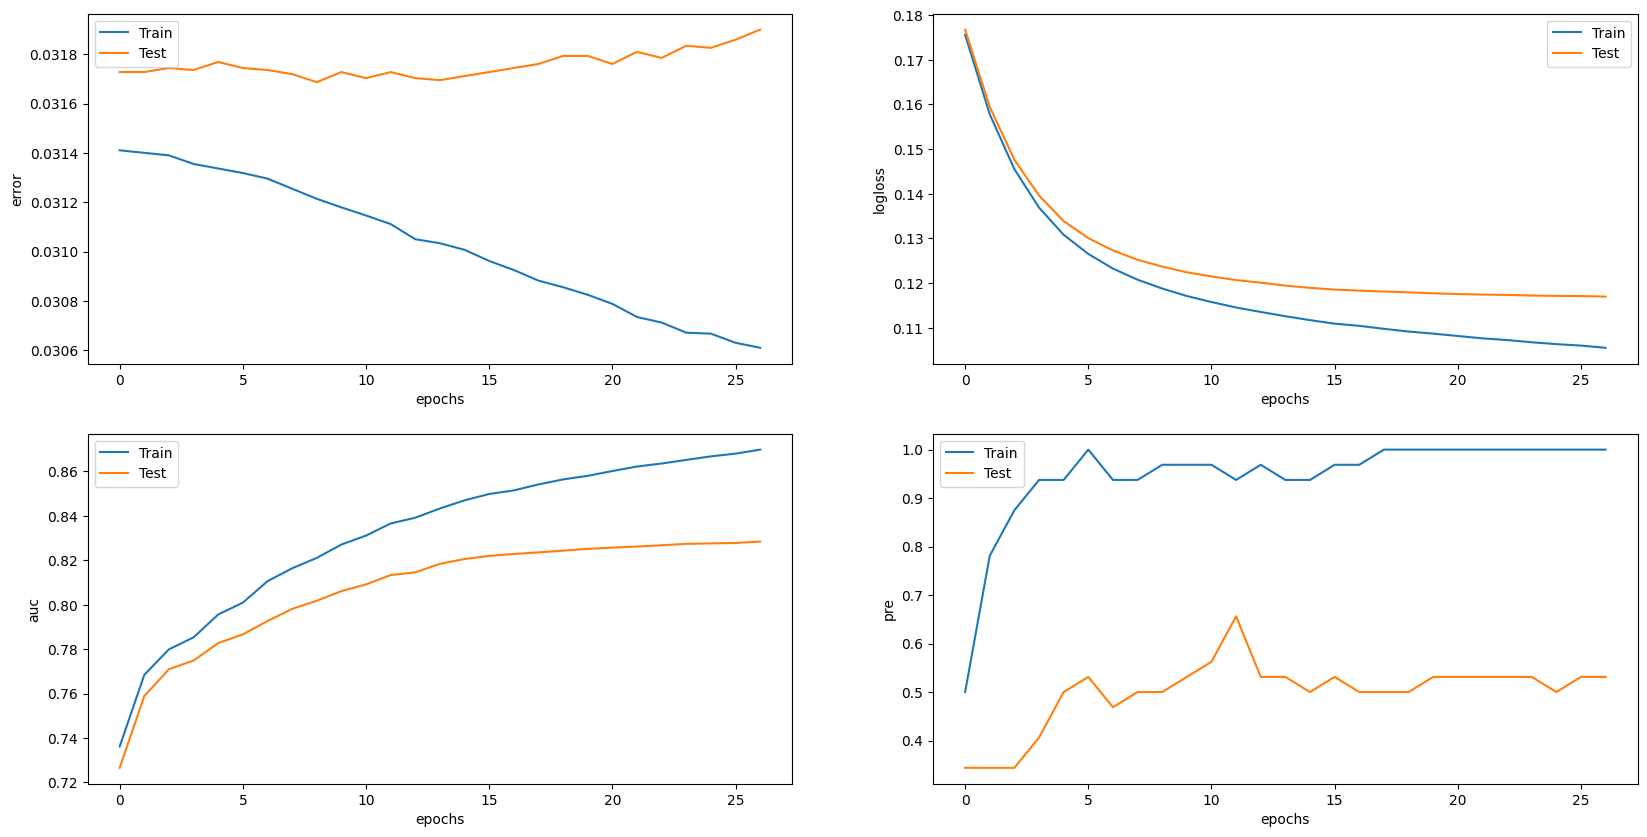

In [31]:
from pprint import pprint

def plot_model_metrics(metrics):
    fig, axs = plt.subplots(len(eval_metrics) // 2, 2, figsize=(10 * (len(eval_metrics) // 2), 5 * 2))

    epochs = len(metrics['validation_0'][eval_metrics[0]])
    x_axis = range(epochs)
    
    for i, metric in enumerate(eval_metrics):
        axs[i // 2][i % 2].plot(x_axis, metrics['validation_0'][metric], label='Train')
        axs[i // 2][i % 2].plot(x_axis, metrics['validation_1'][metric], label='Test')
        axs[i // 2][i % 2].set_ylabel(metric)
        axs[i // 2][i % 2].set_xlabel('epochs')
        axs[i // 2][i % 2].legend()

    plt.show()

plot_model_metrics(model.evals_result())

Let's do a small sanity check to ensure that our model isn't going for all loans paid or something like that - that it's actually creating both defaulted and non defaulted outputs for our predictions.

In [32]:
pl.Series(_y_preds).value_counts()

shape: (2, 2)
┌─────┬────────┐
│     ┆ count  │
│ --- ┆ ---    │
│ i64 ┆ u32    │
╞═════╪════════╡
│ 0   ┆ 122089 │
│ 1   ┆ 44     │
└─────┴────────┘

# Test dataset and submission
Getting rid of train data to reduce memory usage

In [33]:
del train_df
del _X_train, _y_train
del _X_val, _y_val

Load and transform the test data to get `X`.

In [34]:
test_df = feature_engineer_and_merge_dataframes(
    is_test=True,
    base=ParquetReader.read(TEST_DIR / 'test_base.parquet'),
    depth_0=[
        ParquetReader.read_multiple([
            TEST_DIR / 'test_static_0_0.parquet',
            TEST_DIR / 'test_static_0_1.parquet',
            TEST_DIR / 'test_static_0_2.parquet',
        ]),
        ParquetReader.read(TEST_DIR / 'test_static_cb_0.parquet'),
    ],
    depth_1=[
        ParquetReader.read_multiple([
            TEST_DIR / 'test_applprev_1_0.parquet',
            TEST_DIR / 'test_applprev_1_1.parquet',
            TEST_DIR / 'test_applprev_1_2.parquet',
        ], depth=1),
        ParquetReader.read(TEST_DIR / 'test_other_1.parquet', depth=1),
        ParquetReader.read(TEST_DIR / 'test_tax_registry_a_1.parquet', depth=1),
        ParquetReader.read(TEST_DIR / 'test_tax_registry_b_1.parquet', depth=1),
        ParquetReader.read(TEST_DIR / 'test_tax_registry_c_1.parquet', depth=1),
        ParquetReader.read_multiple([
            TEST_DIR / 'test_credit_bureau_a_1_0.parquet',
            TEST_DIR / 'test_credit_bureau_a_1_1.parquet',
            TEST_DIR / 'test_credit_bureau_a_1_2.parquet',
            TEST_DIR / 'test_credit_bureau_a_1_3.parquet',
            TEST_DIR / 'test_credit_bureau_a_1_4.parquet',
        ], depth=1),
        ParquetReader.read(TEST_DIR / 'test_credit_bureau_b_1.parquet', depth=1),
        ParquetReader.read(TEST_DIR / 'test_deposit_1.parquet', depth=1),
        ParquetReader.read(TEST_DIR / 'test_person_1.parquet', depth=1),
        ParquetReader.read(TEST_DIR / 'test_debitcard_1.parquet', depth=1),
    ],
    depth_2=[
        ParquetReader.read(TEST_DIR / 'test_applprev_2.parquet', depth=2),
        ParquetReader.read(TEST_DIR / 'test_person_2.parquet', depth=2),
        ParquetReader.read_multiple([
            TEST_DIR / 'test_credit_bureau_a_2_0.parquet',
            TEST_DIR / 'test_credit_bureau_a_2_1.parquet',
            TEST_DIR / 'test_credit_bureau_a_2_2.parquet',
            TEST_DIR / 'test_credit_bureau_a_2_3.parquet',
            TEST_DIR / 'test_credit_bureau_a_2_4.parquet',
            TEST_DIR / 'test_credit_bureau_a_2_5.parquet',
            TEST_DIR / 'test_credit_bureau_a_2_6.parquet',
            TEST_DIR / 'test_credit_bureau_a_2_7.parquet',
            TEST_DIR / 'test_credit_bureau_a_2_8.parquet',
            TEST_DIR / 'test_credit_bureau_a_2_9.parquet',
            TEST_DIR / 'test_credit_bureau_a_2_10.parquet',
            TEST_DIR / 'test_credit_bureau_a_2_11.parquet',
        ], depth=2),
        ParquetReader.read(TEST_DIR / 'test_credit_bureau_b_2.parquet', depth=2),
    ]
)

DataFrameOps.process_dates / processed:
['datefirstoffer_1144D',
 'datelastinstal40dpd_247D',
 'datelastunpaid_3546854D',
 'dtlastpmtallstes_4499206D',
 'firstclxcampaign_1125D',
 'firstdatedue_489D',
 'lastactivateddate_801D',
 'lastapplicationdate_877D',
 'lastapprdate_640D',
 'lastdelinqdate_224D',
 'lastrejectdate_50D',
 'lastrepayingdate_696D',
 'maxdpdinstldate_3546855D',
 'payvacationpostpone_4187118D',
 'validfrom_1069D',
 'assignmentdate_238D',
 'assignmentdate_4527235D',
 'assignmentdate_4955616D',
 'birthdate_574D',
 'dateofbirth_337D',
 'dateofbirth_342D',
 'responsedate_1012D',
 'responsedate_4527233D',
 'responsedate_4917613D',
 'median_approvaldate_319D',
 'median_creationdate_885D',
 'median_dateactivated_425D',
 'median_dtlastpmt_581D',
 'median_dtlastpmtallstes_3545839D',
 'median_employedfrom_700D',
 'median_firstnonzeroinstldate_307D',
 'median_recorddate_4527225D',
 'median_deductiondate_4917603D',
 'median_processingdate_168D',
 'median_dateofcredend_289D',
 'medi

## Dropping columns we dropped in our train set

In [35]:
test_df, _, _ = drop_nullish_columns(test_df, train_null_stats_df)

## Getting `X_test`

In [36]:
_X_test, _, _transformer = transform_get_X_y(test_df, col_transformer=_transformer)

## Building `y_pred` using the model we trained earlier

In [37]:
_test_preds = model.predict(_X_test)

## Generating the submission file

In [38]:
submission = pl.DataFrame({'case_id': test_df['case_id'], 'score': _test_preds})

submission.to_pandas().to_csv('submission.csv', index=False)

submission

shape: (10, 2)
┌─────────┬───────┐
│ case_id ┆ score │
│ ---     ┆ ---   │
│ i64     ┆ i64   │
╞═════════╪═══════╡
│ 57543   ┆ 0     │
│ 57549   ┆ 0     │
│ 57551   ┆ 0     │
│ 57552   ┆ 0     │
│ 57569   ┆ 0     │
│ 57630   ┆ 0     │
│ 57631   ┆ 0     │
│ 57632   ┆ 0     │
│ 57633   ┆ 0     │
│ 57634   ┆ 0     │
└─────────┴───────┘

# Fin. :)